In [1]:
!pip install heartpy

import os 
import zipfile 
from scipy.io import loadmat 
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import io
from PIL import Image
import tensorflow as tf 
from tensorflow import keras
import sys
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
import pywt 


SEED = 1
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)


In [2]:
#IF Colab cloud GPU used -> Mount the My Drive folder and set cwd
from google.colab import drive
drive.mount('/content/drive')
cwd = '/content/drive/My Drive/FinalAssignment'
os.chdir(cwd)
dataset_folder = os.path.join(cwd,'training_set_dir')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def load_data(sample_prefix, input_dir):    # everything is returned as a numpy array which is easier to manipulate
    label_filepath = os.path.join(input_dir, sample_prefix + '_ann.mat')
    peak_filepath = os.path.join(input_dir, sample_prefix + '_rpk.mat')
    signal_filepath = os.path.join(input_dir, sample_prefix + '.mat')
    if os.path.isfile(label_filepath):
        mat_file = loadmat(label_filepath)
        label = np.asarray(mat_file['labels'])
    if os.path.isfile(peak_filepath):
        mat_file = loadmat(peak_filepath)
        peaks = np.array(mat_file['rpeaks'],dtype=np.int64)
    if os.path.isfile(signal_filepath):
        mat_file = loadmat(signal_filepath)
        signal = np.asarray(mat_file['ecg'] )

    return label, peaks, signal

labels = list()             # labels 
ids = list()                # Id of samples 
rpeaks = list()             # detected peaks of the signal 
ecg_signals = list()        # .mat ecg signal 
frequencies = list()        # sample frequency of the ecg signal 


for f in os.listdir(dataset_folder):
  if f.lower().endswith('.mat'):
    id = f[:4]
    if id not in ids:
      ids.append(id)
      sample_prefix = f[:8]
      label, peak, signal = load_data(sample_prefix, dataset_folder)
      labels.append(label)
      rpeaks.append(peak)
      ecg_signals.append(signal)
      frequencies.append(int(sample_prefix[5:]))

In [4]:
cols = ["sigId","ecg_lead_1","ecg_lead_2","peaks","frequencies","labels"]

# ecg signals is 105 rows [,,,,,]

first_lead_signals = []
second_lead_signals = []

for signal in ecg_signals:
    first_lead_signals.append(signal[:,0].tolist())    # converting the array to list as list of array is deprecated 
    second_lead_signals.append(signal[:,1].tolist())

df = pd.DataFrame(data =[ids,first_lead_signals,second_lead_signals,rpeaks,frequencies,labels]).T
df.columns = cols

# transform peaks 
for id in tqdm(df.index.tolist()):
    peaks = df.iloc[id]['peaks']
    p_list = list()
    for p in peaks:
        p_list.append(p[0])
    df.iloc[id]['peaks'] = np.asarray(p_list).astype(np.int64)

df.head()

100%|██████████| 105/105 [00:00<00:00, 741.61it/s]


,sigId,ecg_lead_1,ecg_lead_2,peaks,frequencies,labels
0,S002,"[-0.035, -0.045, -0.025, -0.035, -0.045, -0.05...","[-0.095, -0.105, -0.095, -0.095, -0.115, -0.09...","[48, 153, 243, 352, 440, 547, 636, 742, 831, 9...",128,"[N, N, N, N, S, N, S, N, S, N, S, N, S, N, S, ..."
1,S001,"[0.0, 0.04, 0.03, 0.0, 0.03, 0.09, 0.18, 0.14,...","[0.08, 0.07, 0.1, 0.06, 0.06, 0.03, 0.1, 0.21,...","[29, 110, 191, 272, 353, 433, 514, 595, 676, 7...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
2,S003,"[-0.56, -0.56, -0.55, -0.47, -0.53, -0.47, -0....","[0.43, 0.56, 0.6, 0.41, 0.54, 0.48, 0.56, 0.46...","[91, 209, 326, 394, 537, 653, 745, 872, 984, 1...",128,"[N, N, N, S, N, N, S, N, N, S, N, N, N, N, N, ..."
3,S004,"[-0.46, -0.49, -0.52, -0.58, -0.62, -0.69, -0....","[0.56, 0.61, 0.66, 0.66, 0.63, 0.66, 0.59, 0.5...","[98, 223, 349, 474, 599, 726, 853, 980, 1116, ...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
4,S005,"[-0.27, -0.17, -0.13, -0.23, -0.18, -0.23, -0....","[-0.02, -0.04, -0.01, -0.01, -0.02, -0.06, 0.0...","[27, 127, 225, 324, 423, 523, 623, 722, 822, 9...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."


In [5]:
# because of the curse of dimensionality --> undersampling 

from scipy.signal import resample

ids_128 = df[df['frequencies'] == 128].index.tolist() # 65 signals are sampled using fs = 128
ids_250 = df[df['frequencies'] == 250].index.tolist() # 65 signals are sampled using fs = 128
sampled_len =  len(df.iloc[ids_250[0]]['ecg_lead_1'])
resampled_len = len(df.iloc[ids_128[0]]['ecg_lead_1'])

for id in tqdm(ids_250):
    row = df.iloc[id]
    # first lead
    signal = np.asarray(row['ecg_lead_1']).astype(np.float32)
    resampled_1 = resample(signal,resampled_len)
    
    # second lead
    
    signal = np.asarray(row['ecg_lead_2']).astype(np.float32)
    resampled_2 = resample(signal,resampled_len)
    
    df.iloc[id]['ecg_lead_1'] = resampled_1.tolist()
    df.iloc[id]['ecg_lead_2'] = resampled_2.tolist()
    
    for i,p in enumerate(list(df.iloc[id]['peaks'])):
        df.iloc[id]['peaks'][i] = int(resampled_len * p/sampled_len)

100%|██████████| 40/40 [00:09<00:00,  4.05it/s]


In [6]:
#Preprocessing used in practical lessons
from scipy.signal import resample, butter, lfilter, iirnotch

def notch_filter(cutoff, fs, q=30):
    nyq = 0.5*fs
    freq = cutoff/nyq
    b, a = iirnotch(freq, q)
    return b, a

#def bandpass_filter(data, filter_order=5, lowcut = .5, highcut = 55, signal_freq=128):
def bandpass_filter(data, filter_order=6, lowcut = 1, highcut = 45, signal_freq=128):
        """
        Method responsible for creating and applying Butterworth filter.
        :param deque data: raw data
        :param float lowcut: filter lowcut frequency value
        :param float highcut: filter highcut frequency value
        :param int signal_freq: signal frequency in samples per second (Hz)
        :param int filter_order: filter order
        :return array: filtered data
        """
        powerline = 60
        nyquist_freq = 0.5 * signal_freq
        low = lowcut / nyquist_freq
        high = highcut / nyquist_freq
        b, a = butter(filter_order, [low, high], btype="band")
        y = lfilter(b, a, data,zi = None)
        #b,a = notch_filter(powerline,signal_freq)
        #y = lfilter(b,a,y)
        return y

['N', 'N', 'V']


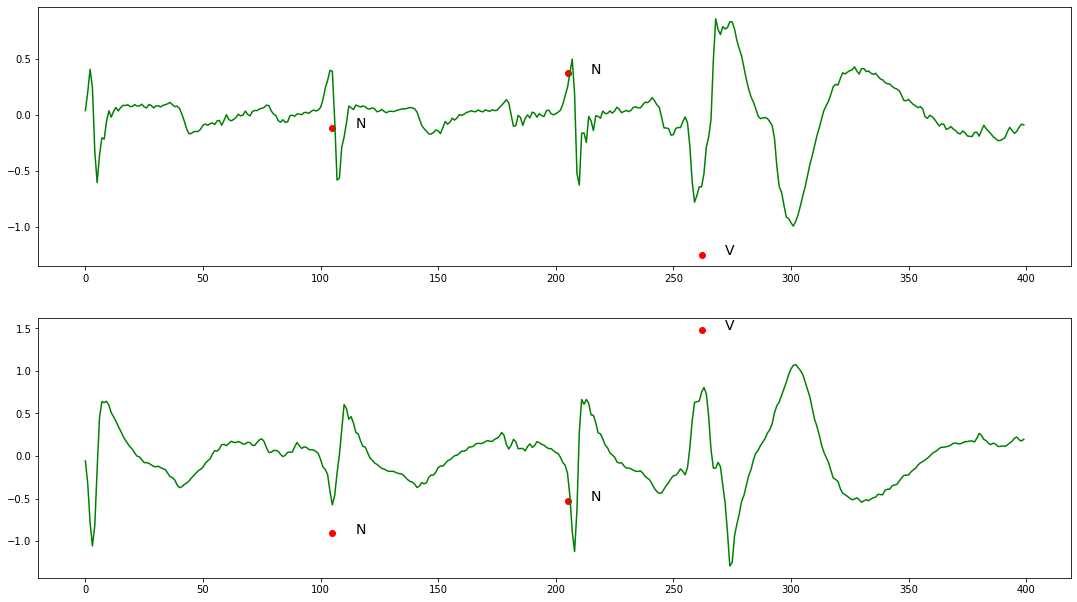

In [7]:
# plot signal 
from scipy.fft import fft, fftfreq

def plot_signal(df,id,length):
    fig,axs = plt.subplots(2)
    fig.set_size_inches(18.5, 10.5)
    ax1 = axs[0]
    ax2 = axs[1]
    
    
    signal = df.iloc[id]
    
    first_lead = signal['ecg_lead_1'][:length]
    second_lead = signal['ecg_lead_2'][:length]
    
    peaks_ = signal['peaks']
    labels_ = signal['labels']
    
    x = list(range(length))
    
    #ax1.plot(x,first_lead,color='blue')
    #ax2.plot(x,second_lead,color='blue')
    
    ax1.plot(x,bandpass_filter(first_lead),color='green')
    ax2.plot(x,bandpass_filter(second_lead),color='green')


    
    peaks = list()
    p_amplitudes_first = list()
    p_amplitudes_second = list()
    labels = list()
    
    for i,p in enumerate(peaks_):
        if(p <= length):
            peaks.append(p)
            p_amplitudes_first.append(first_lead[p])
            p_amplitudes_second.append(second_lead[p])
            labels.append(labels_[i])
        else:
            break
            
    ax1.scatter(peaks,p_amplitudes_first,color='red')
    ax2.scatter(peaks,p_amplitudes_second,color='red')
    offset = 10
    
    for i, txt in enumerate(labels):
        ax1.annotate(txt, (peaks[i]+offset, p_amplitudes_first[i]),size = 14)
        ax2.annotate(txt, (peaks[i]+offset, p_amplitudes_second[i]),size = 14)
    
    print(labels)
    plt.show()

plot_signal(df,10,400)

In [8]:
filtered_df = df.copy(deep= True)

ids = filtered_df.index.tolist()

for id_ in tqdm(ids):
    
    row = filtered_df.iloc[id_]
    first = row['ecg_lead_1']
    second = row['ecg_lead_2']
    filtered_first = np.asarray(bandpass_filter(first))
    filtered_second =  np.asarray(bandpass_filter(second))

    filtered_df.iloc[id_]['ecg_lead_1'] = pd.Series(filtered_first)
    filtered_df.iloc[id_]['ecg_lead_2'] = pd.Series(filtered_second)
   

100%|██████████| 105/105 [00:03<00:00, 31.23it/s]


In [9]:
import heartpy as hp

fs = 128
time_window = 10
samples = fs * time_window ##

for id in tqdm(filtered_df.index.tolist()):
    row = filtered_df.loc[id]
    first_lead = row['ecg_lead_1']
    second_lead = row['ecg_lead_2']
    l_ = len(first_lead)
    scaled_1 = list()
    scaled_2 = list()
#    
    for i in range(int(l_/samples)):
        to_scale_1 = first_lead[i*samples:i*samples+samples] 
        to_scale_2 = second_lead[i*samples:i*samples+samples]
#        
        scaled_1 += list(hp.scale_data(to_scale_1,lower=-1,upper=1))
        scaled_2 += list(hp.scale_data(to_scale_2,lower=-1,upper=1))
 ##   
    filtered_df.loc[id]['ecg_lead_1'] = scaled_1
    filtered_df.loc[id]['ecg_lead_2'] = scaled_2

100%|██████████| 105/105 [00:42<00:00,  2.46it/s]


In [10]:
filtered_df

,sigId,ecg_lead_1,ecg_lead_2,peaks,frequencies,labels
0,S002,"[-0.3092426686134654, -0.3407281552851471, -0....","[0.31541874902246003, 0.21617369900403927, 0.1...","[48, 153, 243, 352, 440, 547, 636, 742, 831, 9...",128,"[N, N, N, N, S, N, S, N, S, N, S, N, S, N, S, ..."
1,S001,"[-0.10124629057096801, -0.09708035104545487, -...","[0.04821271136016647, 0.08175942520080404, 0.1...","[29, 110, 191, 272, 353, 433, 514, 595, 676, 7...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
2,S003,"[-0.21124730442462292, -0.3921294346774953, -0...","[0.1335663861124501, 0.2793473733986551, 0.424...","[91, 209, 326, 394, 537, 653, 745, 872, 984, 1...",128,"[N, N, N, S, N, N, S, N, N, S, N, N, N, N, N, ..."
3,S004,"[-0.2210303045186407, -0.35484856491322303, -0...","[0.30395098618992344, 0.5275282876107985, 0.71...","[98, 223, 349, 474, 599, 726, 853, 980, 1116, ...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
4,S005,"[0.03338602396497192, -0.029153969031567972, -...","[-0.045809476716352604, -0.060011246761204506,...","[27, 127, 225, 324, 423, 523, 623, 722, 822, 9...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
...,...,...,...,...,...,...
100,S114,"[-0.2541137967471856, -0.5462269114313831, -0....","[-0.21418132645172205, -0.533083057296377, -0....","[79, 196, 312, 427, 539, 652, 766, 880, 992, 1...",250,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
101,S115,"[0.10035354942208463, 0.19715287684264093, 0.2...","[-0.07640869378248538, 0.08135235965609766, 0....","[110, 223, 341, 421, 572, 690, 813, 889, 1041,...",250,"[N, N, N, V, N, N, N, V, N, N, N, N, N, N, N, ..."
102,S116,"[-0.41984580457435494, -0.5099571832352312, -0...","[-0.19047616975030446, -0.22468469965613846, -...","[130, 273, 418, 559, 705, 848, 990, 1134, 1276...",250,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
103,S117,"[0.03285567118284938, 0.03634173280526487, 0.0...","[-0.003365798216479421, 0.35983750795165337, 0...","[9, 151, 294, 441, 589, 734, 873, 1021, 1160, ...",250,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."


['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']


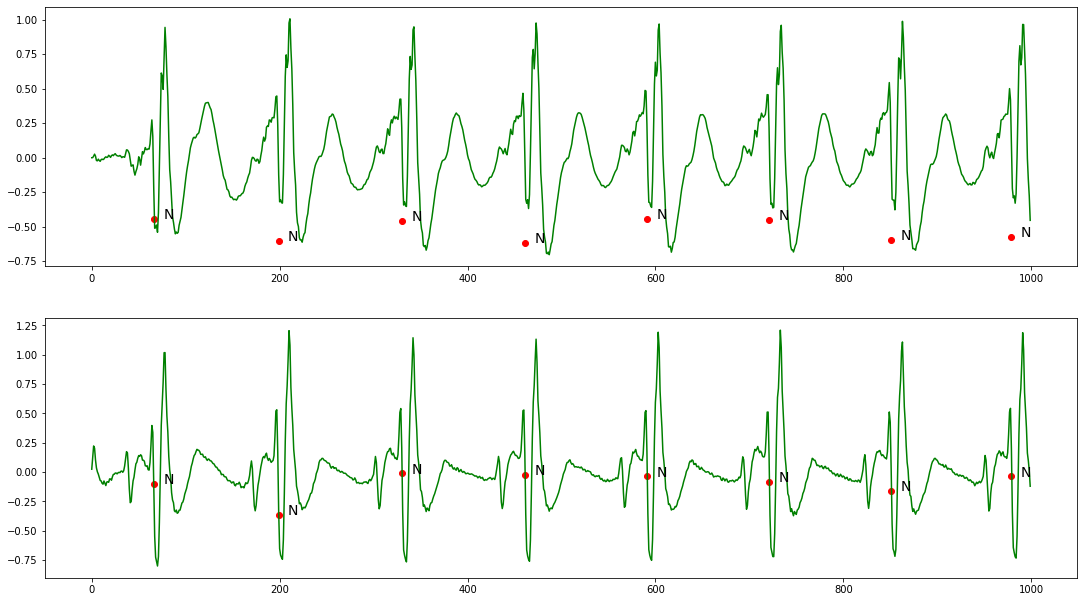

In [13]:
plot_signal(filtered_df,25,1000)

In [14]:
from scipy import stats

# Function for the computation of rhythm data 
def get_2ECG_rhythmfeatures(data):
  
  #   mean
  mean_lead = np.mean(data)

  #   median
  median_lead = np.median(data)

  #   standard deviation
  std_lead = np.std(data)

  #   variance
  var_lead = stats.tvar(data)

  #   Skewness
  skew_lead = stats.skew(data)

  #   Kurtosis
  kurt_lead = stats.kurtosis(data)

  features = np.hstack([mean_lead,median_lead,std_lead,var_lead,skew_lead,kurt_lead])

  return features
#-------------------------------------------------------------------------------

#Training

features_rhythm_lead1 = list()
features_rhythm_lead2 = list()


for i in range(filtered_df.shape[0]):
  tmp_lead1 = get_2ECG_rhythmfeatures(filtered_df['ecg_lead_1'][i])
  features_rhythm_lead1.append(tmp_lead1)
  tmp_lead2 = get_2ECG_rhythmfeatures(filtered_df['ecg_lead_2'][i])
  features_rhythm_lead2.append(tmp_lead2)

features_rhythm_lead1 = pd.DataFrame(features_rhythm_lead1, columns = ['mean_lead1', 'median_lead1', 'std_lead1', 'var_lead1', 'skew_lead1','kurt_lead1'])
features_rhythm_lead2 = pd.DataFrame(features_rhythm_lead2, columns = ['mean_lead2', 'median_lead2', 'std_lead2', 'var_lead2', 'skew_lead2','kurt_lead2'])

features_rhythm = pd.concat([features_rhythm_lead1, features_rhythm_lead2], axis=1)

features = pd.DataFrame(features_rhythm, columns = ['mean_lead1', 'median_lead1', 'std_lead1', 'var_lead1', 'skew_lead1','kurt_lead1',
                                                    'mean_lead2', 'median_lead2', 'std_lead2', 'var_lead2', 'skew_lead2','kurt_lead2'])
display(features) 

,mean_lead1,median_lead1,std_lead1,var_lead1,skew_lead1,kurt_lead1,mean_lead2,median_lead2,std_lead2,var_lead2,skew_lead2,kurt_lead2
0,-0.305167,-0.289756,0.239837,0.057522,1.523904,9.264459,0.354835,0.418840,0.301818,0.091095,-1.128854,3.264988
1,-0.046342,-0.064355,0.252276,0.063644,0.114880,4.267097,0.177652,0.192652,0.240461,0.057822,-1.131610,6.375673
2,-0.003686,-0.004451,0.250848,0.062925,-0.152908,2.424895,0.095233,0.112898,0.259910,0.067554,-0.654586,3.442150
3,-0.159588,-0.152933,0.279951,0.078373,0.846431,3.107136,0.249039,0.243744,0.301853,0.091116,-0.693553,1.916772
4,0.039502,0.046880,0.263466,0.069415,-0.362392,4.312610,0.092585,0.095259,0.285392,0.081449,-0.151251,1.817383
...,...,...,...,...,...,...,...,...,...,...,...,...
100,-0.226730,-0.247675,0.266073,0.070795,0.707053,1.875109,-0.111078,-0.117666,0.216246,0.046763,0.319255,3.269939
101,-0.077886,-0.081577,0.250747,0.062874,0.240804,3.371929,-0.058104,-0.060937,0.251547,0.063276,0.200834,3.295954
102,-0.326942,-0.335653,0.221687,0.049145,1.801725,8.032770,-0.143396,-0.147502,0.221005,0.048843,0.872107,6.696533
103,0.084449,0.108446,0.198281,0.039316,-0.696107,9.400795,-0.067918,-0.094736,0.249356,0.062179,0.424371,1.809654


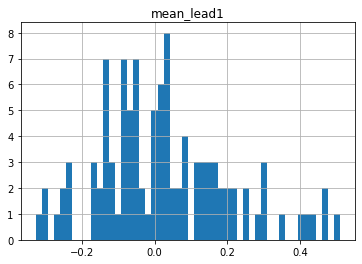

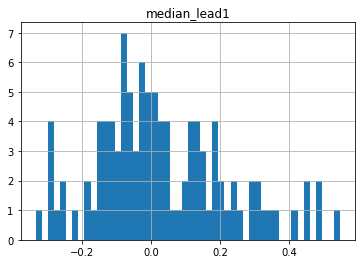

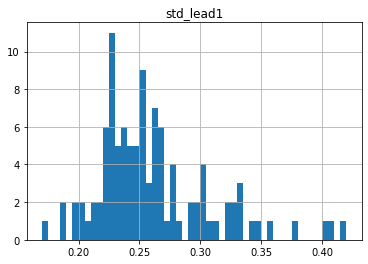

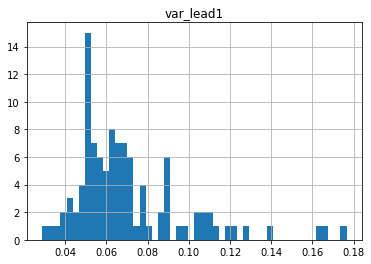

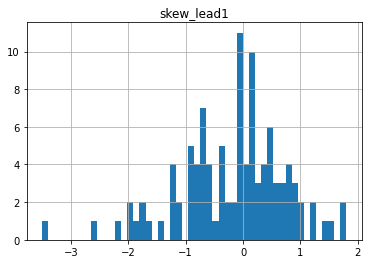

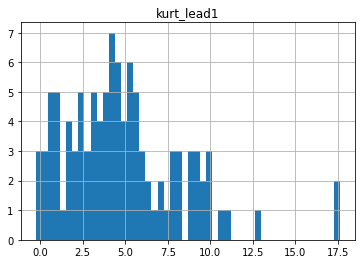

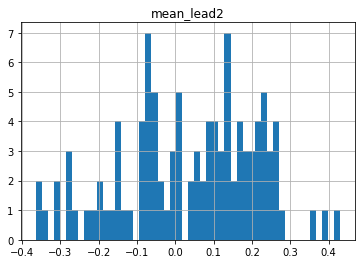

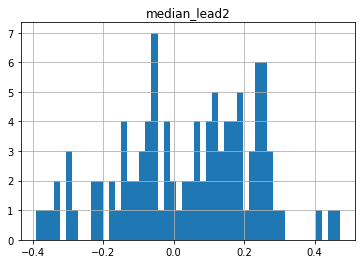

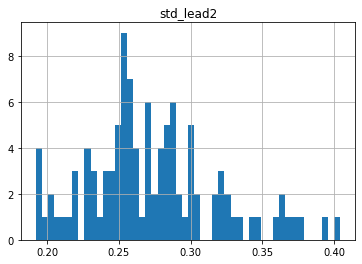

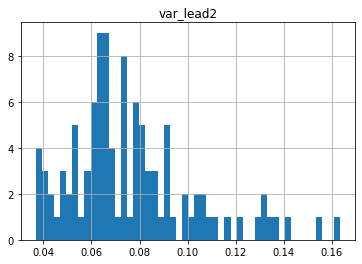

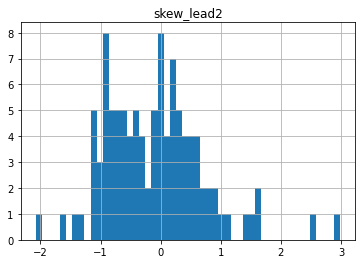

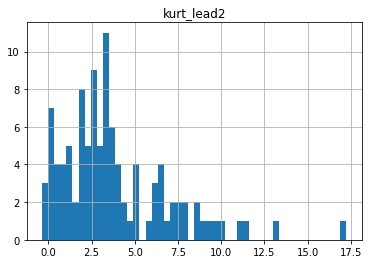

In [15]:
# Visualize data distribution for each feature
for col in features.columns: 
      features.hist(column = col, bins = 50)

In [16]:
def plot_outliersAnalysis(abs_zscores):
  # number of outliers per subject 
  bool_zscores = (abs_zscores > 3).sum(axis=1)
  bool_zscores.hist()
  plt.title("Number of outliers per subject")
  plt.show()

  # number of outliers per feature 
  bool_zscores = (abs_zscores > 3).sum(axis=0)
  #bool_zscores.hist(bins = len(feature_list))
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])

  ax.bar(feature_list,bool_zscores)
  plt.title("Number of outliers per feature")
  plt.xticks(np.arange(len(feature_list)), feature_list,rotation=90)
  plt.show()
  return

Train subjects before outlier removal: (105, 12)
Train subjects after outlier removal: (98, 12)


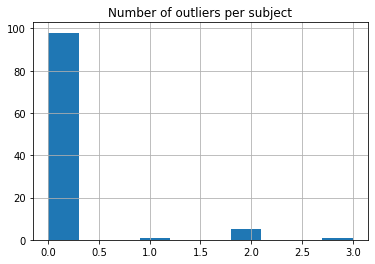

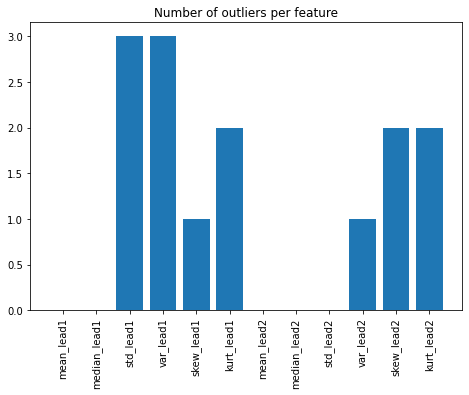

,mean_lead1,median_lead1,std_lead1,var_lead1,skew_lead1,kurt_lead1,mean_lead2,median_lead2,std_lead2,var_lead2,skew_lead2,kurt_lead2
0,-0.305167,-0.289756,0.239837,0.057522,1.523904,9.264459,0.354835,0.418840,0.301818,0.091095,-1.128854,3.264988
1,-0.046342,-0.064355,0.252276,0.063644,0.114880,4.267097,0.177652,0.192652,0.240461,0.057822,-1.131610,6.375673
2,-0.003686,-0.004451,0.250848,0.062925,-0.152908,2.424895,0.095233,0.112898,0.259910,0.067554,-0.654586,3.442150
3,-0.159588,-0.152933,0.279951,0.078373,0.846431,3.107136,0.249039,0.243744,0.301853,0.091116,-0.693553,1.916772
4,0.039502,0.046880,0.263466,0.069415,-0.362392,4.312610,0.092585,0.095259,0.285392,0.081449,-0.151251,1.817383
...,...,...,...,...,...,...,...,...,...,...,...,...
100,-0.226730,-0.247675,0.266073,0.070795,0.707053,1.875109,-0.111078,-0.117666,0.216246,0.046763,0.319255,3.269939
101,-0.077886,-0.081577,0.250747,0.062874,0.240804,3.371929,-0.058104,-0.060937,0.251547,0.063276,0.200834,3.295954
102,-0.326942,-0.335653,0.221687,0.049145,1.801725,8.032770,-0.143396,-0.147502,0.221005,0.048843,0.872107,6.696533
103,0.084449,0.108446,0.198281,0.039316,-0.696107,9.400795,-0.067918,-0.094736,0.249356,0.062179,0.424371,1.809654


In [17]:
# Perform z-scoring for outlier removal
from scipy.stats import zscore
import numpy as np

feature_list = features.columns.tolist()
print('Train subjects before outlier removal: ' + str(features.shape))

# apply zscore
zscore_features = features.apply(zscore, axis=0)

# select all those values with zscore < -+ 3 and discard outliers 
abs_zscores = np.abs(zscore_features)
filtered_entries = (abs_zscores < 3).all(axis=1)

features_or = features[filtered_entries]

print('Train subjects after outlier removal: ' + str(features_or.shape))


plot_outliersAnalysis(abs_zscores)
display(features_or)

In [18]:
features_or.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
             13,  14,  15,  16,  18,  19,  21,  23,  24,  26,  27,  28,  29,
             30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
             43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
             56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
             69,  70,  71,  72,  73,  74,  75,  76,  77,  80,  81,  82,  84,
             85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
             98,  99, 100, 101, 102, 103, 104],
           dtype='int64')

In [19]:
filtered_df = filtered_df.loc[features_or.index]
filtered_df

,sigId,ecg_lead_1,ecg_lead_2,peaks,frequencies,labels
0,S002,"[-0.3092426686134654, -0.3407281552851471, -0....","[0.31541874902246003, 0.21617369900403927, 0.1...","[48, 153, 243, 352, 440, 547, 636, 742, 831, 9...",128,"[N, N, N, N, S, N, S, N, S, N, S, N, S, N, S, ..."
1,S001,"[-0.10124629057096801, -0.09708035104545487, -...","[0.04821271136016647, 0.08175942520080404, 0.1...","[29, 110, 191, 272, 353, 433, 514, 595, 676, 7...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
2,S003,"[-0.21124730442462292, -0.3921294346774953, -0...","[0.1335663861124501, 0.2793473733986551, 0.424...","[91, 209, 326, 394, 537, 653, 745, 872, 984, 1...",128,"[N, N, N, S, N, N, S, N, N, S, N, N, N, N, N, ..."
3,S004,"[-0.2210303045186407, -0.35484856491322303, -0...","[0.30395098618992344, 0.5275282876107985, 0.71...","[98, 223, 349, 474, 599, 726, 853, 980, 1116, ...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
4,S005,"[0.03338602396497192, -0.029153969031567972, -...","[-0.045809476716352604, -0.060011246761204506,...","[27, 127, 225, 324, 423, 523, 623, 722, 822, 9...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
...,...,...,...,...,...,...
100,S114,"[-0.2541137967471856, -0.5462269114313831, -0....","[-0.21418132645172205, -0.533083057296377, -0....","[79, 196, 312, 427, 539, 652, 766, 880, 992, 1...",250,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
101,S115,"[0.10035354942208463, 0.19715287684264093, 0.2...","[-0.07640869378248538, 0.08135235965609766, 0....","[110, 223, 341, 421, 572, 690, 813, 889, 1041,...",250,"[N, N, N, V, N, N, N, V, N, N, N, N, N, N, N, ..."
102,S116,"[-0.41984580457435494, -0.5099571832352312, -0...","[-0.19047616975030446, -0.22468469965613846, -...","[130, 273, 418, 559, 705, 848, 990, 1134, 1276...",250,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
103,S117,"[0.03285567118284938, 0.03634173280526487, 0.0...","[-0.003365798216479421, 0.35983750795165337, 0...","[9, 151, 294, 441, 589, 734, 873, 1021, 1160, ...",250,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."


In [20]:

signal_ids = filtered_df.index.tolist()
RR_dict = {}

for id_ in tqdm(signal_ids):  
  sig_Id = df.iloc[id_]['sigId']
  RR_dict[sig_Id] = {}
  RR_dict[sig_Id]['RR_distances'] = list()
  RR_dict[sig_Id]['S_distances'] = list()
  
  peaks = df.iloc[id_]['peaks']
  labels = df.iloc[id_]['labels']

  for i,p in enumerate(peaks[1:-1]):
    RR_distance = p-peaks[i]
    if(RR_distance < 250): # discard outliers
      RR_dict[sig_Id]['RR_distances'].append(RR_distance)
      if(labels[i+1] == 'S'):
        RR_dict[sig_Id]['S_distances'].append(RR_distance)

  RR_dict[sig_Id]['RR_distances'] = np.asarray(RR_dict[sig_Id]['RR_distances'])
  RR_dict[sig_Id]['S_distances'] = np.asarray(RR_dict[sig_Id]['S_distances'])

  RR_dict[sig_Id]['Avg_RR_distance'] = RR_dict[sig_Id]['RR_distances'].mean()
  RR_dict[sig_Id]['AVG_S_distance'] = RR_dict[sig_Id]['S_distances'].mean()


RR_df = pd.DataFrame.from_dict(RR_dict,orient="index")
RR_df.tail()


100%|██████████| 98/98 [00:00<00:00, 247.79it/s]


,RR_distances,S_distances,Avg_RR_distance,AVG_S_distance
S114,"[117, 116, 115, 112, 113, 114, 114, 112, 116, ...",[],114.914745,NaN
S115,"[113, 118, 80, 151, 118, 123, 76, 152, 119, 11...",[73],89.041006,73.000000
S116,"[143, 145, 141, 146, 143, 142, 144, 142, 143, ...",[75],122.611082,75.000000
S117,"[142, 143, 147, 148, 145, 139, 148, 139, 140, ...","[119, 99, 92, 100, 99, 92, 91, 92, 89, 87, 82,...",106.363048,83.558719
S118,"[85, 84, 86, 81, 82, 85, 81, 83, 83, 82, 84, 8...",[],93.967755,NaN


In [21]:
import heartpy as hp 

classes = np.array(["N","S","V"])

patch_length = 350 

def convert_to_one_hot(label):
    return np.array(classes == label,dtype=np.float32)

def create_patch_dataset(df):
    
    dataset_dict = {}
    ids = df['sigId']
   
    for id in tqdm(ids):
        row = df[df['sigId'] == id]
        sigId = row['sigId'].values[0]
        peaks = row['peaks'].values[0]
        first_lead_signal = row['ecg_lead_1'].values[0]
        second_lead_signal = row['ecg_lead_2'].values[0]
        labels = row['labels'].values[0]
        avg_RR = RR_df.loc[sigId]['Avg_RR_distance'] # T for the signal 

        for i,peak in enumerate(peaks):
            
            stringIdx = str(sigId)+'_'+str(i)    
            dataset_dict[stringIdx] = {}
            dataset_dict[stringIdx]["first_lead"] = list()
            dataset_dict[stringIdx]["second_lead"] = list()
            size = list(range(int(peak-(avg_RR)),int(peak+avg_RR)))

            for s in size:
                if(s < 0 or s >= len(first_lead_signal)):
                    dataset_dict[stringIdx]["first_lead"].append(0.)
                    dataset_dict[stringIdx]["second_lead"].append(0.)
                else:
                    dataset_dict[stringIdx]["first_lead"].append(first_lead_signal[s])
                    dataset_dict[stringIdx]["second_lead"].append(second_lead_signal[s])
            
            first_lead = dataset_dict[stringIdx]["first_lead"][:]
            second_lead = dataset_dict[stringIdx]["second_lead"][:]
            
            first_lead = resample(first_lead,patch_length)
            second_lead = resample(second_lead,patch_length)
            
            dataset_dict[stringIdx]["first_lead"] = first_lead[:]
            dataset_dict[stringIdx]["second_lead"] = second_lead[:]
            
            dataset_dict[stringIdx]["dwt_1"] = pywt.dwt(first_lead,'db4','constant')
            dataset_dict[stringIdx]["dwt_2"] = pywt.dwt(second_lead,'db4','constant')
            
            dataset_dict[stringIdx]["stringLabel"] = labels[i]
            dataset_dict[stringIdx]["label"] = convert_to_one_hot(labels[i])

    dataset_df = pd.DataFrame.from_dict(dataset_dict,orient="index")
    return dataset_df


In [22]:
validation_percentage = 0.2
training_df, validation_df = train_test_split(filtered_df,test_size = validation_percentage,random_state=SEED)

training_patches_df_ = create_patch_dataset(training_df)
validation_patches_df_ = create_patch_dataset(validation_df)

100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


In [23]:
'''
def plot_patch(id):
    fig,ax = plt.subplots()
    y1 = training_patches_df_.loc[id]['first_lead']
    y2 = training_patches_df_.loc[id]['second_lead']
    x = list(range(len(y1)))
    ax.plot(x,y1,color='green')
    plt.show()
    
ids_V = training_patches_df_.index[training_patches_df_['stringLabel'] == 'V'].tolist()
ids_S = training_patches_df_.index[training_patches_df_['stringLabel'] == 'S'].tolist()
ids_N = training_patches_df_.index[training_patches_df_['stringLabel'] == 'N'].tolist()
print(ids_V[:10])
plot_patch(ids_S[10])
plot_patch(ids_N[222])
plot_patch(ids_V[222])
'''

"\ndef plot_patch(id):\n    fig,ax = plt.subplots()\n    y1 = training_patches_df_.loc[id]['first_lead']\n    y2 = training_patches_df_.loc[id]['second_lead']\n    x = list(range(len(y1)))\n    ax.plot(x,y1,color='green')\n    plt.show()\n    \nids_V = training_patches_df_.index[training_patches_df_['stringLabel'] == 'V'].tolist()\nids_S = training_patches_df_.index[training_patches_df_['stringLabel'] == 'S'].tolist()\nids_N = training_patches_df_.index[training_patches_df_['stringLabel'] == 'N'].tolist()\nprint(ids_V[:10])\nplot_patch(ids_S[10])\nplot_patch(ids_N[222])\nplot_patch(ids_V[222])\n"

How many training indx: 166501
Balancing training...
pre drop: 180663
post drop:22554
44404
769
1810
Balancing validation


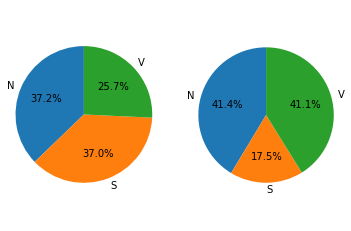

In [24]:

training_patches_df = training_patches_df_.copy(deep=True)
validation_patches_df = validation_patches_df_.copy(deep=True)

training_df.head()

training_patients = training_df['sigId']
validation_patients = validation_df['sigId']

# calculate percentage of heartbeats to drop 

num_n = len(training_patches_df[(training_patches_df['stringLabel']=='N')])
num_s = len(training_patches_df[(training_patches_df['stringLabel']=='S')])
num_v = len(training_patches_df[(training_patches_df['stringLabel']=='V')])
to_drop = num_n - max(num_s,num_v)
perc_to_drop_train = to_drop/(num_n)

num_n = len(validation_patches_df[(validation_patches_df['stringLabel']=='N')])
num_s = len(validation_patches_df[(validation_patches_df['stringLabel']=='S')])
num_v = len(validation_patches_df[(validation_patches_df['stringLabel']=='V')])
to_drop = num_n - max(num_s,num_v)
perc_to_drop_valid = to_drop/(num_n)

train_indexes = training_patches_df.index[training_patches_df['stringLabel'] == 'N'].tolist()
valid_indexes = validation_patches_df.index[validation_patches_df['stringLabel'] == 'N'].tolist()

print(f"How many training indx: {len(train_indexes)}")

train_to_drop = list()
valid_to_drop = list()
lengths = list()
dict_train = {}
valid_train = {}

print("Balancing training...")

for p in training_patients:
    dict_train[p] = list()

for hb in train_indexes:
    dict_train[hb.split('_')[0]].append(hb)

for p in dict_train:
   random.shuffle(dict_train[p])

for k in dict_train:
    train_to_drop += dict_train[k][:int(len(dict_train[k]) * perc_to_drop_train)]

print(f"pre drop: {len(training_patches_df.index)}")
training_patches_df = training_patches_df.drop(train_to_drop)
print(f"post drop:{len(training_patches_df.index)}")
print(num_n)
print(num_s)
print(num_v)
print("Balancing validation")

for p in validation_patients:
    valid_train[p] = list()
    
for hb in valid_indexes:
    valid_train[hb.split('_')[0]].append(hb)

for p in valid_train:
    random.shuffle(valid_train[p])

for k in valid_train:
    valid_to_drop += valid_train[k][:int(perc_to_drop_valid * len(valid_train[k]))]

validation_balanced_patches_df = validation_patches_df.drop(valid_to_drop)


training_labels = training_patches_df['stringLabel'].values
validation_labels = validation_balanced_patches_df['stringLabel'].values

classes = ["N","S","V"]

training_counts = [0]*3
validation_counts = [0]*3

for l in training_labels:
    training_counts[classes.index(l)] += 1
for l in validation_labels:
    validation_counts[classes.index(l)] += 1

fig1, (ax1,ax2) = plt.subplots(1,2)

ax1.pie(training_counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  
ax2.pie(validation_counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax2.axis('equal')  

fig1.set_facecolor("white")

plt.show()


In [25]:
'''
# Drop some N samples 
augmenting_coefficient = 2

num_n = len(training_patches_df[(training_patches_df['stringLabel']=='N')])
num_s = len(training_patches_df[(training_patches_df['stringLabel']=='S')])
num_v = len(training_patches_df[(training_patches_df['stringLabel']=='V')])

#to_drop =(num_n - (max(num_s,num_v)))*9//10
to_drop =(num_n - (min(num_s,num_v)))

ids_n = training_patches_df[training_patches_df['stringLabel'] == 'N'].index.tolist()
random.shuffle(ids_n)

ids_to_drop = ids_n[:to_drop]

training_patches_df = training_patches_df.drop(ids_to_drop)

num_n = len(validation_patches_df[(validation_patches_df['stringLabel']=='N')])
num_s = len(validation_patches_df[(validation_patches_df['stringLabel']=='S')])
num_v = len(validation_patches_df[(validation_patches_df['stringLabel']=='V')])

#to_drop =(num_n - (max(num_s,num_v)))*9//10
to_drop =(num_n - (min(num_s,num_v)))
valid_copy = validation_patches_df.copy()

ids_n = validation_patches_df[validation_patches_df['stringLabel'] == 'N'].index.tolist()
random.shuffle(ids_n)

ids_to_drop = ids_n[:to_drop]

validation_patches_df = validation_patches_df.drop(ids_to_drop)
'''

"\n# Drop some N samples \naugmenting_coefficient = 2\n\nnum_n = len(training_patches_df[(training_patches_df['stringLabel']=='N')])\nnum_s = len(training_patches_df[(training_patches_df['stringLabel']=='S')])\nnum_v = len(training_patches_df[(training_patches_df['stringLabel']=='V')])\n\n#to_drop =(num_n - (max(num_s,num_v)))*9//10\nto_drop =(num_n - (min(num_s,num_v)))\n\nids_n = training_patches_df[training_patches_df['stringLabel'] == 'N'].index.tolist()\nrandom.shuffle(ids_n)\n\nids_to_drop = ids_n[:to_drop]\n\ntraining_patches_df = training_patches_df.drop(ids_to_drop)\n\nnum_n = len(validation_patches_df[(validation_patches_df['stringLabel']=='N')])\nnum_s = len(validation_patches_df[(validation_patches_df['stringLabel']=='S')])\nnum_v = len(validation_patches_df[(validation_patches_df['stringLabel']=='V')])\n\n#to_drop =(num_n - (max(num_s,num_v)))*9//10\nto_drop =(num_n - (min(num_s,num_v)))\nvalid_copy = validation_patches_df.copy()\n\nids_n = validation_patches_df[validation

In [26]:
import seaborn as sns
def plot_confusion_matrix(y_true, y_pred):
  """
    :param ndarray y_true: contains the ground truth labels in the shape (n_samples,)
    :param ndarray y_pred: contains the predicted labels in the shape (n_samples,)
  """
  con_mat = tf.math.confusion_matrix(labels=np.squeeze(y_true), predictions=np.rint(np.squeeze(y_pred))).numpy()
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
  con_mat_df = pd.DataFrame(con_mat_norm,
                  index = classes, 
                  columns = classes)
  figure = plt.figure(figsize=(8, 8))
  sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

In [27]:
def create_input(df,step):
    
    x = list()
    y = list()
    
    for id in tqdm(df.index.tolist()):
        row = df.loc[id]
        x.append(np.transpose(np.asarray([row['first_lead'],row['second_lead']]).astype(np.float32)))
        if step == 1:
          y.append(row['stringLabel']!='N')
        elif step == 2:
          y.append(row['stringLabel']!='S')
        else:
          if row['stringLabel'] == 'N':
            y.append(0)
          elif row['stringLabel'] == 'S':
            y.append(1)
          else:
            y.append(2)

    x = np.asarray(x).astype(np.float32)
    y = np.asarray(y).astype(np.float32)
    

    return x,y

In [28]:
x_train,y_train = create_input(training_patches_df,step=1)
x_valid,y_valid = create_input(validation_balanced_patches_df,step=1)
x_valid_original, y_valid_original = create_input(validation_patches_df, step=1)

100%|██████████| 46983/46983 [00:06<00:00, 7053.16it/s]


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
timesteps = 350 #patch size
channels_num = 2

input = keras.layers.Input(shape=(timesteps, channels_num))

conv1 = keras.layers.Conv1D(filters=32,kernel_size=25,activation="relu")(input)
maxPool1 = keras.layers.MaxPool1D(pool_size=2)(conv1)
dropout1 = keras.layers.Dropout(0.05)(maxPool1)
conv2 = keras.layers.Conv1D(filters=64,kernel_size=12,activation="relu")(dropout1)
maxPool2 = keras.layers.MaxPool1D(pool_size=2)(conv2)
dropout2 = keras.layers.Dropout(0.1)(maxPool2)
conv3 = keras.layers.Conv1D(filters=128,kernel_size=9,activation="relu")(dropout2)
maxPool3 = keras.layers.MaxPool1D(pool_size=2)(conv3)
dropout3 = keras.layers.Dropout(0.15)(maxPool3)
lstm1 = keras.layers.LSTM(64, return_sequences=True)(dropout3)
lstm2 = keras.layers.LSTM(64, return_sequences=False)(lstm1)
output = keras.layers.Dense(1, activation=tf.nn.sigmoid)(lstm2)
model_NvsRest = keras.models.Model(inputs=input, outputs=output)

model_NvsRest.summary()

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,mode="auto", restore_best_weights=True)

batch_size = 128
learning_rate = 1e-4 #best 1e-4 (0.96, 0.98), 5e-5 (0.88, 0.96)
model_NvsRest.compile(
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate),
    loss = 'binary_crossentropy',
    metrics = ['accuracy'],
    
)

class_weights = compute_class_weight(
                                            class_weight = 'balanced', 
                                            classes = y_train, 
                                            y = y_train
                                        )
d_class_weights = dict(enumerate(class_weights))

history = model_NvsRest.fit(
    x = x_train,
    y = y_train, 
    batch_size = batch_size,
    steps_per_epoch=len(x_train)/batch_size,
    validation_data=(x_valid, y_valid),
    epochs = 100,
    shuffle = True,
    callbacks=[callback],
    class_weight = d_class_weights
).history

y_pred = model_NvsRest.predict(x_valid_original)
classes = ["N","Rest"]
plot_confusion_matrix(y_valid_original, y_pred)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 350, 2)]          0         
                                                                 
 conv1d (Conv1D)             (None, 326, 32)           1632      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 163, 32)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 163, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 152, 64)           24640     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 76, 64)           0         
 1D)                                                         

In [ ]:
classes = np.array(["S","V"])
training_patches_df_red = training_patches_df[training_patches_df['stringLabel']!='N']
validation_balanced_patches_df_red = validation_balanced_patches_df[validation_balanced_patches_df['stringLabel']!='N']
validation_patches_df_red = validation_patches_df[validation_patches_df['stringLabel']!='N']

In [ ]:
# count classes for training

ids_s = training_patches_df_red.index[training_patches_df_red['stringLabel'] == 'S'].tolist() 
ids_v = training_patches_df_red.index[training_patches_df_red['stringLabel'] == 'V'].tolist() 

print(f"S: {len(ids_s)}")
print(f"V: {len(ids_v)}")

classes = ["S","V"]
counts = [len(ids_s),len(ids_v)]

fig1, ax1 = plt.subplots()
ax1.pie(counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.set_facecolor("white")
plt.show()

# count classes for validation

ids_n = validation_balanced_patches_df_red.index[validation_balanced_patches_df_red['stringLabel'] == 'S'].tolist() 
ids_rest = validation_balanced_patches_df_red.index[validation_balanced_patches_df_red['stringLabel'] == 'V'].tolist() 

print(f"S: {len(ids_s)}")
print(f"V: {len(ids_v)}")

counts = [len(ids_s),len(ids_v)]

fig1, ax1 = plt.subplots()
ax1.pie(counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.set_facecolor("white")
plt.show()

In [ ]:
x_train,y_train = create_input(training_patches_df_red, step=2)
x_valid,y_valid = create_input(validation_balanced_patches_df_red, step=2)
x_valid_original, y_valid_original = create_input(validation_patches_df_red, step=2)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
timesteps = 350 #patch size
channels_num = 2

input = keras.layers.Input(shape=(timesteps, channels_num))

conv1 = keras.layers.Conv1D(filters=32,kernel_size=25,activation="relu")(input)
maxPool1 = keras.layers.MaxPool1D(pool_size=2)(conv1)
dropout1 = keras.layers.Dropout(0.05)(maxPool1)
conv2 = keras.layers.Conv1D(filters=64,kernel_size=12,activation="relu")(dropout1)
maxPool2 = keras.layers.MaxPool1D(pool_size=2)(conv2)
dropout2 = keras.layers.Dropout(0.1)(maxPool2)
conv3 = keras.layers.Conv1D(filters=128,kernel_size=9,activation="relu")(dropout2)
maxPool3 = keras.layers.MaxPool1D(pool_size=2)(conv3)
dropout3 = keras.layers.Dropout(0.15)(maxPool3)
lstm1 = keras.layers.LSTM(64, return_sequences=True)(dropout3)
lstm2 = keras.layers.LSTM(64, return_sequences=False)(lstm1)
output = keras.layers.Dense(1, activation=tf.nn.sigmoid)(lstm2)
model_SvsV = keras.models.Model(inputs=input, outputs=output)

model_SvsV.summary()

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,mode="auto", restore_best_weights=True)

batch_size = 32 #best 64
learning_rate = 3e-6 #best 5e-5 (0.9, 0.77) with 64, or 5e-4 (0.95,0.79) with 32, or 5e-5 (0.8, 0.89) with 32,  or 1e-5 (0.82, 0.84) with 32, (without outliers 3e-6 (0.96, 0.9) with 32)
model_SvsV.compile(
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate),
    loss = 'binary_crossentropy',
    metrics = ['accuracy'],
    
)

class_weights = compute_class_weight(
                                            class_weight = 'balanced', 
                                            classes = y_train, 
                                            y = y_train
                                        )
d_class_weights = dict(enumerate(class_weights))

history = model_SvsV.fit(
    x = x_train,
    y = y_train, 
    batch_size = batch_size,
    steps_per_epoch=len(x_train)/batch_size,
    validation_data=(x_valid, y_valid),
    epochs = 100,
    shuffle = True,
    callbacks=[callback],
    class_weight = d_class_weights
).history


y_pred = model_SvsV.predict(x_valid)
classes = ["S","V"]
plot_confusion_matrix(y_valid, y_pred)

In [ ]:
x_test,y_test = create_input(validation_patches_df,step=3)

pred_NvsRest = model_NvsRest.predict(x_test)
pred_fin = np.rint(np.squeeze(pred_NvsRest))

x_test_SvsV = x_test[pred_fin == 1]

y_pred = model_SvsV.predict(x_test_SvsV)
pred_SvsV = np.rint(np.squeeze(y_pred))

k = 0;
for i in range(len(pred_fin)):
  if pred_fin[i] == 1:
    if pred_SvsV[k] == 0:
      pred_fin[i] = 1
    else:
      pred_fin[i] = 2
    k += 1;

classes = ["N","S","V"]
plot_confusion_matrix(y_test, pred_fin)